Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
import numpy as np
import requests

API_KEY = 'ei_98b6c42cd610ed6b1f4354ff1d2b8ccb2a0bc1694b165bfda5fa2ff0ea93bea5'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/38744/training/5/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/38744/training/5/y')


Store the data in a temporary file, and load it back through Numpy.

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

In [3]:
X.shape, Y.shape

((253, 650), (253,))

In [4]:
image = X[0]
img_length = image.shape[0]
img_length

650

In [5]:
columns = 13
rows = int(img_length / columns)
image = np.reshape(image, (rows, columns))
image.shape

(50, 13)

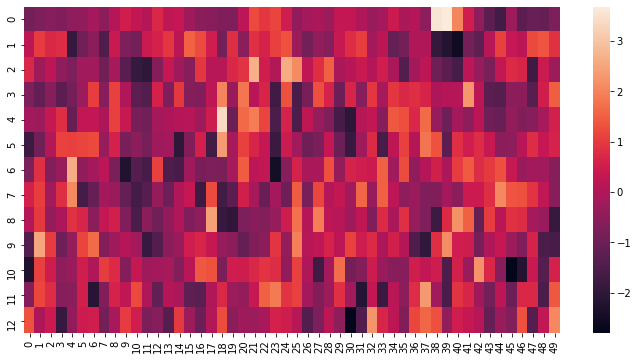

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(image.T);


Define our labels and split the data up in a test and training set:

In [8]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "iesti", "silence", "unifei" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


Train the model:

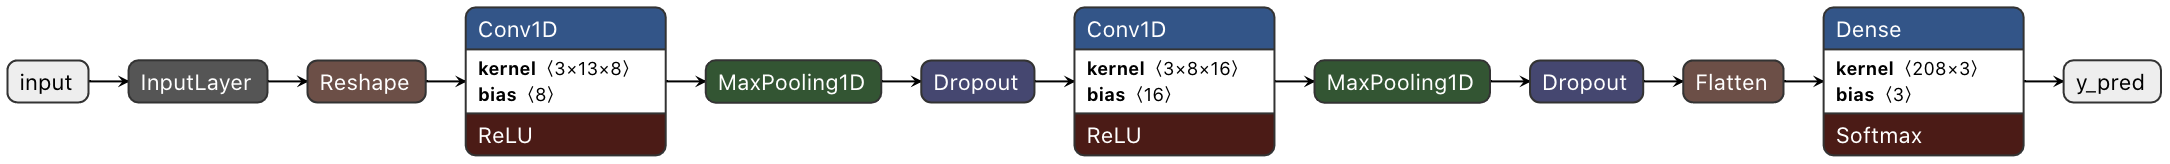

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 13), 13), input_shape=(input_length, )))
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(classes, activation='softmax', name='y_pred'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 50, 13)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 8)             320       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 8)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 16)            400       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 16)            0

In [10]:
# this controls the learning rate
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, verbose=2, callbacks=callbacks)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
7/7 - 1s - loss: 1.5462 - accuracy: 0.3515 - val_loss: 1.2138 - val_accuracy: 0.4510
Epoch 2/100
7/7 - 0s - loss: 1.1160 - accuracy: 0.4158 - val_loss: 1.0198 - val_accuracy: 0.4902
Epoch 3/100
7/7 - 0s - loss: 0.9460 - accuracy: 0.4752 - val_loss: 0.9424 - val_accuracy: 0.5686
Epoch 4/100
7/7 - 0s - loss: 0.8452 - accuracy: 0.6089 - val_loss: 0.9369 - val_accuracy: 0.5882
Epoch 5/100
7/7 - 0s - loss: 0.7809 - accuracy: 0.6782 - val_loss: 0.9163 - val_accuracy: 0.6078
Epoch 6/100
7/7 - 0s - loss: 0.7208 - accuracy: 0.6782 - val_loss: 0.8764 - val_accuracy: 0.7059
Epoch 7/100
7/7 - 0s - loss: 0.6647 - accuracy: 0.7426 - val_loss: 0.8754 - val_accuracy: 0.7059
Epoch 8/100
7/7 - 0s - loss: 0.6001 - accuracy: 0.7475 - val_loss: 0.8498 - val_accuracy: 0.6667
Epoch 9/100
7/7 - 0s - loss: 0.5813 - accuracy: 0.7426 - val_loss: 0.8184 - val_accuracy: 0.6863
Epoch 10/100
7/7 - 0s - loss: 0.4962 - accuracy: 0.8168 - val_loss: 0.7905 - val_accuracy: 0.7451
Epoch 11/100
7/7 - 0s - loss:

In [11]:
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

def plot_result(history, res= 'loss'):
    plt.plot(history.history[res])
    plt.plot(history.history['val_'+res])
    plt.title(res+' vs. epochs')
    plt.ylabel(res)
    plt.xlabel('Epoch')
    if res == 'loss':
        plt.legend(['Training', res], loc='upper right')
    else:
        plt.legend(['Training', res], loc='lower right')
    plt.show() 


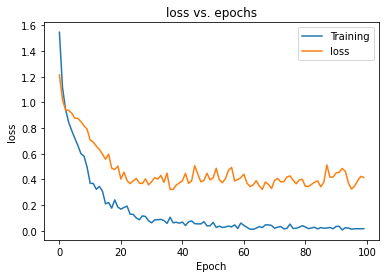

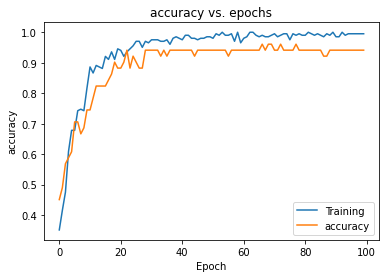

accuracy: 0.941


In [12]:
plot_result(history, res= 'loss')
plot_result(history, res= 'accuracy')
get_test_accuracy(model, X_test, Y_test)

In [13]:
# Save the model to disk
model.save('cnn_v1_saved_model')

Convert and save TF model to a tflite model

In [16]:
# Convert TF model to a tflite model
from tensorflow.keras.models import load_model

model_cnn_v1 = load_model('cnn_v1_saved_model')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_size = open("cnn_v1.tflite","wb").write(tflite_model)
print("Quantized model (DEFAULT) is {:,} bytes".format(tflite_model_size))

Quantized model (DEFAULT) is 11,536 bytes
